# Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1)

In [2]:
catalog = pd.read_csv('data/data_catalogue.csv')
arena_members = pd.read_csv('data/data_arena_members.csv')
arenas = pd.read_csv('data/data_arenas.csv')

In [3]:
arena_members = arena_members.merge(arenas[['arena_id', 'battle_type_id', 'battle_level_id', 'winner_team_id']], how='left', on='arena_id')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,2790,15,20,16533,0,0,0,1,9,2
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,829,15,10,4468,0,0,0,1,9,2
2,2018-09-16,7N1T221ccNyadyccT,202,ca7N4y2y1,1,0,0,0,3873,348,...,240,15,10,5419,1030,0,0,1,9,2
3,2018-09-16,7N1T221ccNyadyccT,202,ca1a2y2cy,1,0,0,0,529,330,...,343,15,10,18874,0,0,0,1,9,2
4,2018-09-16,7N1T221ccNyadyccT,202,caca47y7a,2,0,0,0,10257,379,...,3190,15,20,10470,840,0,0,1,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2427925,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,494,15,10,26773,1560,0,0,1,8,1
2427926,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,1415,15,10,3869,1790,0,0,1,8,1
2427927,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,380,15,10,58261,390,0,0,1,8,1
2427928,2018-10-10,cTacc2711d4da4y,202,c44d7NNNa,2,500138173,0,0,15649,336,...,337,15,10,27681,0,0,0,1,8,1


# Utils

In [4]:
def plot_hist2d(x,
                y,
                title,
                xlabel,
                ylabel,
                ax,
                bins=(50,50),
                cmap=plt.cm.BuPu):
    ax.hist2d(x, y, bins=bins, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def price_distributions(catalog,
                        price='creds'):
    if not price in ['creds', 'gold']:
        raise ValueError('Can display only creds and gold distibutions!')
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,30))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Level {i + 1}')
        ax.hist(catalog[catalog['item_level']==i+1]['item_price_credit' if price=='creds' else 'item_price_gold'].values, \
                bins=20)
    plt.show()
    
def get_regression_line(x,
                        y,
                        degree):
    params = np.polyfit(x, y, degree)
    poly = np.poly1d(params)
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = poly(x_grid)
    return x_grid, y_grid

def build_network(inputs):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[inputs]),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    loss = tf.keras.losses.MSE

    model.compile(loss=loss,
                  optimizer=optimizer)
    
    return model

def plot_network_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.plot(hist['epoch'], hist['loss'], label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='Val loss')
        
    plt.ylim([0,1])
    plt.legend()

    plt.show()

# Catalog cleaning

In [5]:
removed_tanks = pd.DataFrame()

masks = [
    ('cleaning by crew_size: 2 <= crew_size <= 6', \
    (catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)),
    
    ('cleaning by 1 level: item_price_credit = item_price_gold = 0', \
    (catalog['item_level'] != 1) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0))),
    
    ('cleaning by price: item_price_credit > 100 or item_price_gold > 100', \
    (catalog['item_level'] == 1) | \
    (((catalog['item_price_credit'] > 100) & (catalog['item_price_gold'] == 0)) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] > 100)))),
    
    ('custom cleaning by price 2 level: 2000 < item_price_credit < 20000', \
    (catalog['item_level'] != 2) | (catalog['item_price_gold'] != 0) | \
    (catalog['item_price_credit'] > 2000) & (catalog['item_price_credit'] < 20000)),
    
    ('custom cleaning by price 5 level: item_price_credit < 500000', \
    (catalog['item_level'] != 5) | \
    (catalog['item_price_gold'] != 0) | (catalog['item_price_credit'] < 500000)),
    
    ('cleaning by premium: item_level <= 8', \
    (catalog['item_price_gold'] == 0) | (catalog['item_level'] <= 8))
]

for mask in masks:
    N = len(catalog)
    
    removed_tanks = pd.concat([removed_tanks, catalog.loc[~mask[1]]])
    catalog = catalog.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(catalog)} rows. ({100 * (1 - len(catalog) / N)} %)')
    
catalog.index = np.arange(len(catalog))
removed_tanks.index = np.arange(len(removed_tanks))

print(f'\nTotally removed {len(removed_tanks)} rows. ({100 * len(removed_tanks) / (len(removed_tanks) + len(catalog))} %)')

[CLEANING BY CREW_SIZE: 2 <= CREW_SIZE <= 6]: removed 7 rows. (0.7882882882882858 %)
[CLEANING BY 1 LEVEL: ITEM_PRICE_CREDIT = ITEM_PRICE_GOLD = 0]: removed 9 rows. (1.0215664018161208 %)
[CLEANING BY PRICE: ITEM_PRICE_CREDIT > 100 OR ITEM_PRICE_GOLD > 100]: removed 98 rows. (11.238532110091748 %)
[CUSTOM CLEANING BY PRICE 2 LEVEL: 2000 < ITEM_PRICE_CREDIT < 20000]: removed 20 rows. (2.5839793281653756 %)
[CUSTOM CLEANING BY PRICE 5 LEVEL: ITEM_PRICE_CREDIT < 500000]: removed 1 rows. (0.13262599469495706 %)
[CLEANING BY PREMIUM: ITEM_LEVEL <= 8]: removed 18 rows. (2.39043824701195 %)

Totally removed 153 rows. (17.22972972972973 %)


In [6]:
for feature in ['item_cd']:
    catalog[feature] = pd.Categorical(catalog[feature])

classEncoder = OneHotEncoder()
ohe_df = pd.DataFrame(classEncoder.fit_transform(catalog['item_class'].values.reshape(-1, 1)).toarray())
ohe_df.columns = [f'item_class_{i}' for i in range(len(ohe_df.columns))]

catalog = pd.concat([catalog, ohe_df], axis=1)

catalog

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size,item_class_0,item_class_1,item_class_2,item_class_3,item_class_4
0,1,mediumTank,356700,0,5,4,0.0,0.0,0.0,0.0,1.0
1,17,mediumTank,373000,0,5,5,0.0,0.0,0.0,0.0,1.0
2,33,heavyTank,0,1500,5,5,0.0,0.0,1.0,0.0,0.0
3,49,mediumTank,0,7500,8,4,0.0,0.0,0.0,0.0,1.0
4,81,mediumTank,0,0,1,5,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
730,64817,lightTank,0,3500,6,5,0.0,0.0,0.0,1.0,0.0
731,65041,SPG,0,0,1,6,0.0,1.0,0.0,0.0,0.0
732,65073,heavyTank,0,12250,8,4,0.0,0.0,1.0,0.0,0.0
733,65297,heavyTank,0,12500,8,5,0.0,0.0,1.0,0.0,0.0


In [7]:
N0 = len(catalog)

print(f'Catalog shape: {catalog.shape}\n')

N = len(catalog)
print('[REMOVING DUPLICATES...]', end='   ')
catalog = catalog.dropna()
print(f'[REMOVED: {N - len(catalog)}] ({100 * (1 - len(catalog) / N)} %)')

N = len(catalog)
print('[REMOVING NAN...]', end='   ')
catalog = catalog[~catalog.isna()]
print(f'[REMOVED: {N - len(catalog)}] ({100 * (1 - len(catalog) / N)} %)')

print(f'\nTotally removed {N0 - len(catalog)} rows. ({100 * (1 - len(catalog) / N0)} %)\n')

catalog.info()

Catalog shape: (735, 11)

[REMOVING DUPLICATES...]   [REMOVED: 0] (0.0 %)
[REMOVING NAN...]   [REMOVED: 0] (0.0 %)

Totally removed 0 rows. (0.0 %)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 734
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   item_cd            735 non-null    category
 1   item_class         735 non-null    object  
 2   item_price_credit  735 non-null    int64   
 3   item_price_gold    735 non-null    int64   
 4   item_level         735 non-null    int64   
 5   crew_size          735 non-null    int64   
 6   item_class_0       735 non-null    float64 
 7   item_class_1       735 non-null    float64 
 8   item_class_2       735 non-null    float64 
 9   item_class_3       735 non-null    float64 
 10  item_class_4       735 non-null    float64 
dtypes: category(1), float64(5), int64(4), object(1)
memory usage: 90.3+ KB


In [8]:
s1 = set(removed_tanks['item_cd'])
s2 = set(arena_members['vehicle_type_cd'])

removed_ids = s1.intersection(s2)

print(removed_ids)

{13889, 58625, 61697, 15905, 46849, 15617, 65281, 58369, 55841, 9297, 6225, 63537, 58641, 60945}


# Catalog visualizing

In [ ]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

degree = 3
prices = creds_catalog[['item_level', 'item_price_credit']].values

plot_hist2d(x=creds_catalog['item_level'],
            y=creds_catalog['item_price_credit'],
            title='Price credits distribution by level',
            xlabel='Level',
            ylabel='Price credits',
            ax=axs[0])
axs[0].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

degree = 3
prices = gold_catalog[['item_level', 'item_price_gold']].values

plot_hist2d(x=gold_catalog['item_level'],
            y=gold_catalog['item_price_gold'],
            title='Price gold distribution by level',
            xlabel='Level',
            ylabel='Price gold',
            ax=axs[1])
axs[1].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

plt.show()

In [ ]:
price_distributions(creds_catalog, price='creds')

In [ ]:
price_distributions(gold_catalog, price='gold')

In [ ]:
sns.countplot(catalog['item_class']);

In [ ]:
sns.countplot(catalog['item_level']);

In [ ]:
sns.countplot(catalog['crew_size']);

# Arenas data cleaning

In [9]:
N0 = len(arena_members)

masks = [
    ('sync with catalog: vehicle_type_cd not in removed_ids', \
    ~arena_members['vehicle_type_cd'].isin(removed_ids)),
    
    ('removing not standard battles: battle_type_id == 1', \
    arena_members['battle_type_id'] == 1)
]

for mask in masks:
    N = len(arena_members)
    
    arena_members = arena_members.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N)} %)')
    
arena_members.index = np.arange(len(arena_members))

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

[SYNC WITH CATALOG: VEHICLE_TYPE_CD NOT IN REMOVED_IDS]: removed 6806 rows. (0.28032109657197823 %)
[REMOVING NOT STANDARD BATTLES: BATTLE_TYPE_ID == 1]: removed 34193 rows. (1.4122779337200408 %)

Totally removed 40999 rows. (1.6886401173015653 %)


In [10]:
for feature in ['clan_db_id', 'is_prebattle_creator']:
    arena_members[feature] = pd.Categorical(arena_members[feature])

arena_members['dt'] = pd.to_datetime(arena_members['dt'])

In [11]:
N0 = len(arena_members)

print(f'Arena members shape: {arena_members.shape}\n')

N = len(arena_members)
print('[REMOVING DUPLICATES...]', end='   ')
arena_members = arena_members.dropna()
print(f'[REMOVED: {N - len(arena_members)}] ({100 * (1 - len(arena_members) / N)} %)')

N = len(arena_members)
print('[REMOVING NAN...]', end='   ')
arena_members = arena_members[~arena_members.isna()]
print(f'[REMOVED: {N - len(arena_members)}] ({100 * (1 - len(arena_members) / N)} %)')

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

arena_members.info()

Arena members shape: (2386931, 38)

[REMOVING DUPLICATES...]   [REMOVED: 0] (0.0 %)
[REMOVING NAN...]   [REMOVED: 0] (0.0 %)

Totally removed 0 rows. (0.0 %)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2386931 entries, 0 to 2386930
Data columns (total 38 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   dt                        datetime64[ns]
 1   arena_id                  object        
 2   periphery_id              int64         
 3   account_db_id             object        
 4   team_id                   int64         
 5   clan_db_id                category      
 6   prebattle_id              int64         
 7   is_prebattle_creator      category      
 8   vehicle_type_cd           int64         
 9   life_time_sec             int64         
 10  shots                     int64         
 11  hits                      int64         
 12  he_hits                   int64         
 13  pierced                   int64   

# Creating normed by time features

In [12]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0

normalize_feature = np.vectorize(normalize_feature)

In [13]:
arena_members['total_damage_dealt'] = arena_members['damage_dealt'] + arena_members['damage_assisted_radio'] + \
                                      arena_members['damage_assisted_stun'] + arena_members['damage_assisted_track']

arena_members['life_time_min'] = arena_members['life_time_sec'] / 60

# Restoring winrates

In [ ]:
def calc_winner(row):
    winner = 0
    if row['num_tanks_pos_1'] != 0 and row['num_tanks_pos_2'] == 0:
        winner = 1
    elif row['num_tanks_pos_2'] != 0 and row['num_tanks_pos_1'] == 0:
        winner = 2
    else:
        if row['mean_xp_1'] / row['mean_xp_2'] > 1.8:
            winner = 1
        elif row['mean_xp_2'] / row['mean_xp_1'] > 1.8:
            winner = 2
        else:
            winner = 0
    return winner

arena_members['is_alive'] = arena_members['remained_hp'] > 0

N = len(arena_members)
print('[FILTERING DATA FOR FULL 15x15 TEAMS...]', end='  ')
arena_members = arena_members[arena_members.groupby('arena_id')['account_db_id'].transform('count') == 30]
arena_members.index = np.arange(len(arena_members))
print(f'[FILTERED]: removed {N - len(arena_members)} rows!')

print('[GROUPING BATTLES AND TEAMS...]', end='  ')
battles = arena_members.groupby(['arena_id', 'team_id'])
print(f'[GROUPED BATTLES AND TEAMS]: There are {sum(battles["account_db_id"].count() != 15)} not full teams!')

print('[CALCULATING STATS...]', end='  ')
info_df = pd.DataFrame(index = [ind[0] for ind in battles.count().index][::2])
info_df['num_tanks_pos_1'] = battles['is_alive'].sum().iloc[::2].values
info_df['num_tanks_pos_2'] = battles['is_alive'].sum().iloc[1::2].values
info_df['mean_xp_1'] = battles['original_xp'].mean().iloc[::2].values
info_df['mean_xp_2'] = battles['original_xp'].mean().iloc[1::2].values
print(f'[CALCULATED STATS]: There are {len(battles) // 2} restored battles!')
    
print('[CALCULATING WINNERS...]', end='  ')
info_df['winner_team_id_my'] = info_df.apply(calc_winner, axis=1)
print('[CALCULATED WINNERS]')

print('[JOINING...]', end='  ')
info_df.reset_index(inplace=True)
arena_members = arena_members.merge(info_df[['index', 'winner_team_id_my']], how='left', left_on='arena_id', right_on='index')
arena_members.drop(columns=['index'], inplace=True, axis=1)
print('[JOINED]')

arena_members['is_winner_my'] = arena_members['team_id'] == arena_members['winner_team_id_my']

In [14]:
arena_members['is_winner'] = arena_members['team_id'] == arena_members['winner_team_id']

In [ ]:
print(f"Our algorithm accuracy = {100 - 100 * abs(arena_members['is_winner'].sum() - arena_members['is_winner_my'].sum()) / len(arena_members)} %")

Critical battles number = 5.0


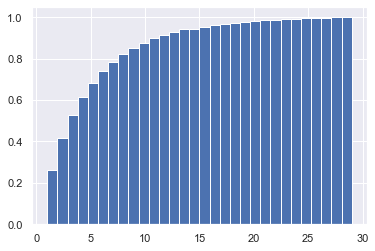

In [15]:
player_battles = arena_members.groupby('account_db_id')['account_db_id'].count()

battles_critical = np.percentile(player_battles, 65)
print(f'Critical battles number = {battles_critical}')

plt.hist(player_battles[player_battles < 30], bins=30, density=True, cumulative=True)
plt.show()

In [16]:
N = len(arena_members)

print('[FILTERING BY CRITICAL BATTLES NUMBER...]', end='   ')
arena_members = arena_members[arena_members.groupby('account_db_id')['account_db_id'].transform('count') > battles_critical]
print(f'[FILTERED: removed {N - len(arena_members)} rows.] ({100 - 100 * len(arena_members) / N} %)')

arena_members

[FILTERING BY CRITICAL BATTLES NUMBER...]   [FILTERED: removed 724425 rows.] (30.349641443342932 %)


,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_winner
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,16533,0,0,0,1,9,2,3075,6.316667,True
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,4468,0,0,0,1,9,2,2607,6.316667,True
7,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,101557,1310,0,1343,1,9,2,2401,5.616667,True
8,2018-09-16,7N1T221ccNyadyccT,202,cac4a2121,2,0,0,0,529,379,...,25209,0,0,0,1,9,2,1659,6.316667,True
12,2018-09-16,7N1T221ccNyadyccT,202,caa4TTcdc,1,0,0,0,2593,259,...,6195,0,0,0,1,9,2,81,4.316667,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386925,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,13135,0,0,0,1,8,1,2076,8.483333,False
2386926,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,26773,1560,0,0,1,8,1,1377,2.983333,False
2386927,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,3869,1790,0,0,1,8,1,2619,5.100000,True
2386928,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,58261,390,0,0,1,8,1,1011,5.566667,False


In [17]:
players_for_train = arena_members[arena_members.groupby('account_db_id')['account_db_id'].transform('count') >= 10]
players_for_train = players_for_train.groupby('account_db_id').agg({'original_xp' : 'mean',
                                                                    'remained_hp' : 'mean',
                                                                    'kills_made' : 'mean',
                                                                    'total_damage_dealt' : 'mean',
                                                                    'damaged' : 'mean',
                                                                    'pierced' : 'mean',
                                                                    'original_credits' : 'mean',
                                                                    'hits' : 'mean',
                                                                    'life_time_min' : 'mean',
                                                                    'damage_assisted_track' : 'mean',
                                                                    'spotted' : 'mean',
                                                                    'pierced_received' : 'mean',
                                                                    'is_winner' : lambda g: sum(g) / len(g)})

features = ['mean_original_xp', 'mean_remained_hp', 'mean_kills_made', 'mean_total_damage_dealt',
                            'mean_damaged', 'mean_pierced', 'mean_original_credits', 'mean_hits',
                            'mean_life_time_min', 'mean_damage_assisted_track', 'mean_spotted', 'mean_pierced_received']
target = ['player_winrate']
players_for_train.columns = features + target

players_for_train

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate
account_db_id,,,,,,,,,,,,,
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000
c21117c21,1003.500000,125.500000,0.900000,1171.400000,1.600000,2.000000,20049.000000,3.100000,4.856667,18.100000,0.400000,3.900000,0.400000
c21117yd2,1258.700000,242.200000,0.500000,1830.800000,3.500000,5.000000,29542.100000,8.000000,4.896667,215.400000,0.900000,4.200000,0.500000
c2111Ncyd,1456.937500,174.229167,1.062500,2285.625000,3.937500,6.645833,70518.937500,9.583333,4.234722,112.916667,1.583333,3.645833,0.583333
c2111TTa7,267.923077,166.769231,0.307692,469.692308,1.461538,1.923077,7834.153846,4.153846,5.701282,0.000000,0.307692,2.615385,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyydN4N,717.600000,25.600000,0.400000,792.800000,2.100000,2.200000,19133.900000,4.000000,4.303333,82.000000,0.300000,4.300000,0.400000
cyyyydyNa,1348.230769,61.615385,0.461538,958.923077,1.692308,2.076923,39881.307692,2.846154,2.833333,57.307692,2.076923,4.000000,0.461538
cyyyyy2y2,1387.592593,197.111111,0.703704,1642.666667,2.444444,3.296296,48332.925926,4.555556,4.640741,212.407407,1.222222,3.444444,0.629630


In [18]:
players_feature_scaler, players_winrate_scaler = StandardScaler(), StandardScaler()

Xn = players_feature_scaler.fit_transform(players_for_train[features])
Yn = players_winrate_scaler.fit_transform(players_for_train[target])

pcaWinrate = PCA(n_components=0.95)
pcaWinrate_components = pcaWinrate.fit_transform(Xn)

numWinrateComponents = pcaWinrate_components.shape[1]

model = GradientBoostingRegressor(n_estimators=300, max_depth=8)
model.fit(Xn, Yn.reshape(len(Yn),))

print(pcaWinrate.explained_variance_ratio_)

preds = model.predict(Xn)
mean_squared_error(Yn, preds)

[0.46907906 0.18406394 0.07097152 0.06703235 0.05929998 0.04174647
 0.03059228 0.02863616]


0.36484396351706105

In [19]:
players_data = arena_members.groupby('account_db_id').agg({'original_xp' : 'mean',
                                                           'remained_hp' : 'mean',
                                                           'kills_made' : 'mean',
                                                           'total_damage_dealt' : 'mean',
                                                           'damaged' : 'mean',
                                                           'pierced' : 'mean',
                                                           'original_credits' : 'mean',
                                                           'hits' : 'mean',
                                                           'life_time_min' : 'mean',
                                                           'damage_assisted_track' : 'mean',
                                                           'spotted' : 'mean',
                                                           'pierced_received' : 'mean',
                                                           'is_winner' : lambda g: sum(g) / len(g)})
players_data.columns = features + target

players_data

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate
account_db_id,,,,,,,,,,,,,
c21112TT1,965.000000,69.000000,0.571429,1753.285714,2.142857,5.000000,23514.000000,5.857143,3.759524,231.857143,1.428571,5.000000,0.571429
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000
c21114TaT,784.111111,149.777778,1.333333,2595.000000,5.222222,6.111111,29309.888889,9.444444,5.453704,55.444444,1.222222,4.111111,0.555556
c211172d7,595.142857,256.285714,0.857143,1366.142857,2.714286,4.142857,27680.428571,5.000000,3.876190,35.000000,1.428571,4.142857,0.285714
c211177a2,1251.000000,522.833333,1.166667,1982.500000,3.500000,3.666667,18619.000000,5.833333,4.986111,539.666667,0.333333,3.333333,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyy2ac,1098.375000,212.375000,0.375000,1556.125000,3.125000,3.375000,41397.625000,5.125000,4.679167,0.000000,0.250000,3.500000,0.500000
cyyyyy2y2,1387.592593,197.111111,0.703704,1642.666667,2.444444,3.296296,48332.925926,4.555556,4.640741,212.407407,1.222222,3.444444,0.629630
cyyyyy2yd,1025.090909,222.545455,0.545455,2218.272727,2.818182,3.000000,31261.636364,3.909091,4.245455,72.909091,1.000000,3.181818,0.545455


In [20]:
players_features_normed = players_feature_scaler.transform(players_data[features])
winrateComponents = pcaWinrate.transform(players_features_normed)[:, numWinrateComponents - 1]

players_winrate_normed = model.predict(players_features_normed)
players_data['player_winrate_ML'] = players_winrate_scaler.inverse_transform(players_winrate_normed)

players_data['player_winrate_ML'][players_data['player_winrate_ML'] < 0] = 0
players_data['player_winrate_ML'][players_data['player_winrate_ML'] > 1] = 1

players_data

,mean_original_xp,mean_remained_hp,mean_kills_made,mean_total_damage_dealt,mean_damaged,mean_pierced,mean_original_credits,mean_hits,mean_life_time_min,mean_damage_assisted_track,mean_spotted,mean_pierced_received,player_winrate,player_winrate_ML
account_db_id,,,,,,,,,,,,,,
c21112TT1,965.000000,69.000000,0.571429,1753.285714,2.142857,5.000000,23514.000000,5.857143,3.759524,231.857143,1.428571,5.000000,0.571429,0.520047
c21114Naa,669.600000,360.350000,1.000000,1735.000000,3.450000,4.400000,23421.200000,6.450000,6.022500,94.650000,1.050000,2.500000,0.600000,0.522096
c21114TaT,784.111111,149.777778,1.333333,2595.000000,5.222222,6.111111,29309.888889,9.444444,5.453704,55.444444,1.222222,4.111111,0.555556,0.454719
c211172d7,595.142857,256.285714,0.857143,1366.142857,2.714286,4.142857,27680.428571,5.000000,3.876190,35.000000,1.428571,4.142857,0.285714,0.455307
c211177a2,1251.000000,522.833333,1.166667,1982.500000,3.500000,3.666667,18619.000000,5.833333,4.986111,539.666667,0.333333,3.333333,0.500000,0.671702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cyyyyy2ac,1098.375000,212.375000,0.375000,1556.125000,3.125000,3.375000,41397.625000,5.125000,4.679167,0.000000,0.250000,3.500000,0.500000,0.474884
cyyyyy2y2,1387.592593,197.111111,0.703704,1642.666667,2.444444,3.296296,48332.925926,4.555556,4.640741,212.407407,1.222222,3.444444,0.629630,0.568518
cyyyyy2yd,1025.090909,222.545455,0.545455,2218.272727,2.818182,3.000000,31261.636364,3.909091,4.245455,72.909091,1.000000,3.181818,0.545455,0.537232


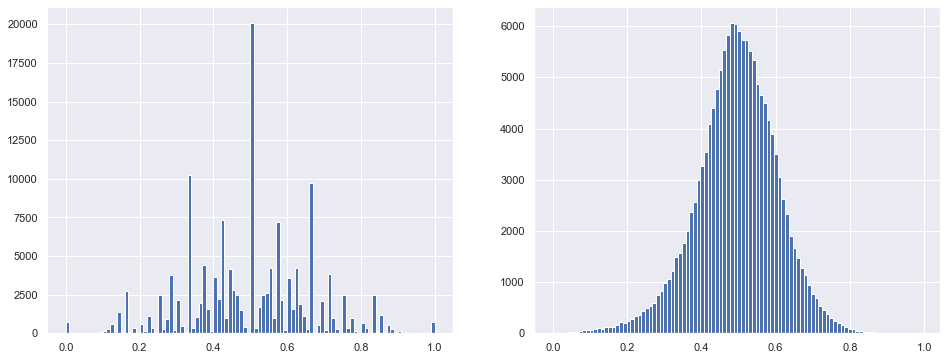

0.49476467255907197

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(players_data['player_winrate'], bins=100)
axes[1].hist(players_data['player_winrate_ML'], bins=100)
plt.show()

players_data['player_winrate_ML'].mean()

In [22]:
arena_members = arena_members.merge(players_data[['player_winrate_ML']], how='left', on='account_db_id')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_winner,player_winrate_ML
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,0,0,0,1,9,2,3075,6.316667,True,0.588878
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,0,0,0,1,9,2,2607,6.316667,True,0.488365
2,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,1310,0,1343,1,9,2,2401,5.616667,True,0.432511
3,2018-09-16,7N1T221ccNyadyccT,202,cac4a2121,2,0,0,0,529,379,...,0,0,0,1,9,2,1659,6.316667,True,0.580664
4,2018-09-16,7N1T221ccNyadyccT,202,caa4TTcdc,1,0,0,0,2593,259,...,0,0,0,1,9,2,81,4.316667,False,0.517746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662501,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,0,0,0,1,8,1,2076,8.483333,False,0.393219
1662502,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,1560,0,0,1,8,1,1377,2.983333,False,0.405415
1662503,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,1790,0,0,1,8,1,2619,5.100000,True,0.617668
1662504,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,390,0,0,1,8,1,1011,5.566667,False,0.616335


Critical battles number = 103


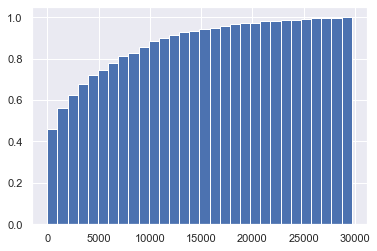

In [23]:
tank_battles = arena_members.groupby('vehicle_type_cd')['vehicle_type_cd'].count()

battles_critical = int(np.percentile(tank_battles, 15))
print(f'Critical battles number = {battles_critical}')

plt.hist(tank_battles[tank_battles < 35000], bins=30, density=True, cumulative=True)
plt.show()

In [24]:
N0 = len(arena_members)

masks = [
    (f'cleaning by tank battles: vehicle_type_cd.grouped.count > {battles_critical}', \
    arena_members.groupby('vehicle_type_cd')['vehicle_type_cd'].transform('count') > battles_critical),
    
    ('cleaning by afk: mileage_meter == 0 & damage_dealt == 0', \
    (arena_members['mileage_meter'] != 0) | (arena_members['damage_dealt'] != 0))
]

for mask in masks:
    N = len(arena_members)
    
    arena_members = arena_members.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N)} %)')
    
arena_members.index = np.arange(len(arena_members))

print(f'\nTotally removed {N0 - len(arena_members)} rows. ({100 * (1 - len(arena_members) / N0)} %)')

[CLEANING BY TANK BATTLES: VEHICLE_TYPE_CD.GROUPED.COUNT > 103]: removed 2807 rows. (0.16884149591038788 %)
[CLEANING BY AFK: MILEAGE_METER == 0 & DAMAGE_DEALT == 0]: removed 2543 rows. (0.15322055384741073 %)

Totally removed 5350 rows. (0.32180334988264336 %)


In [25]:
tanks_data = arena_members.groupby('vehicle_type_cd').agg({'is_winner' : lambda g: sum(g) / len(g)})
tanks_data.columns = ['tank_winrate']

tanks_data

,tank_winrate
vehicle_type_cd,
49,0.506267
145,0.463636
273,0.464602
305,0.519171
513,0.511283
...,...
64065,0.500746
64273,0.471309
64561,0.505991


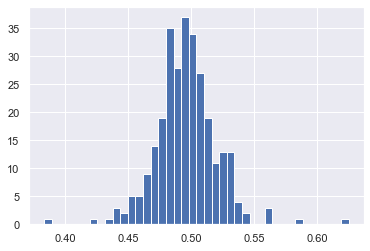

0.4960140233751385

In [26]:
plt.hist(tanks_data['tank_winrate'], bins=40)
plt.show()

tanks_data['tank_winrate'].mean()

In [27]:
arena_members = arena_members.merge(tanks_data[['tank_winrate']], how='left', on='vehicle_type_cd')
arena_members

,dt,arena_id,periphery_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,...,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_winner,player_winrate_ML,tank_winrate
0,2018-09-16,7N1T221ccNyadyccT,202,cyNd17y1T,2,0,0,0,7457,379,...,0,0,1,9,2,3075,6.316667,True,0.588878,0.506973
1,2018-09-16,7N1T221ccNyadyccT,202,c2c1cN211,2,0,0,0,5377,379,...,0,0,1,9,2,2607,6.316667,True,0.488365,0.493767
2,2018-09-16,7N1T221ccNyadyccT,202,cdyN74Ndd,2,500021711,0,0,2961,337,...,0,1343,1,9,2,2401,5.616667,True,0.432511,0.505860
3,2018-09-16,7N1T221ccNyadyccT,202,cac4a2121,2,0,0,0,529,379,...,0,0,1,9,2,1659,6.316667,True,0.580664,0.483986
4,2018-09-16,7N1T221ccNyadyccT,202,caa4TTcdc,1,0,0,0,2593,259,...,0,0,1,9,2,81,4.316667,False,0.517746,0.485520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,2018-10-10,cTacc2711d4da4y,202,cyaNa1y41,2,500146221,0,0,61713,509,...,0,0,1,8,1,2076,8.483333,False,0.393219,0.488701
1657152,2018-10-10,cTacc2711d4da4y,202,cdNNTdcca,2,500047395,0,0,9217,179,...,0,0,1,8,1,1377,2.983333,False,0.405415,0.497093
1657153,2018-10-10,cTacc2711d4da4y,202,ccaT7TTc1,1,500157804,0,0,65073,306,...,0,0,1,8,1,2619,5.100000,True,0.617668,0.495933
1657154,2018-10-10,cTacc2711d4da4y,202,cdNc2N1aa,2,500053396,0,0,59137,334,...,0,0,1,8,1,1011,5.566667,False,0.616335,0.515528


In [29]:
arena_members.drop(columns=['dt', 'periphery_id', 'team_id', 'clan_db_id', 'prebattle_id', 'is_prebattle_creator',
                            'life_time_sec', 'shots', 'hits', 'he_hits', 'pierced', 'mileage_meter', 'premium_xp_factor',
                            'daily_xp_factor', 'battle_num', 'remained_hp', 'is_alive', 'winner_team_id',
                            'winner_team_id_my', 'is_winner', 'is_winner_my'], inplace=True, axis=1)
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,booster_bonus_credits,booster_bonus_xp,battle_type_id,battle_level_id,winner_team_id,total_damage_dealt,life_time_min,is_winner,player_winrate_ML,tank_winrate
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,0,0,1,9,2,3075,6.316667,True,0.588878,0.506973
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,0,0,1,9,2,2607,6.316667,True,0.488365,0.493767
2,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,0,1343,1,9,2,2401,5.616667,True,0.432511,0.505860
3,7N1T221ccNyadyccT,cac4a2121,529,1659,0,0,0,965,7,0,...,0,0,1,9,2,1659,6.316667,True,0.580664,0.483986
4,7N1T221ccNyadyccT,caa4TTcdc,2593,0,81,0,0,1650,6,1,...,0,0,1,9,2,81,4.316667,False,0.517746,0.485520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,0,0,1,8,1,2076,8.483333,False,0.393219,0.488701
1657152,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,0,0,1,8,1,1377,2.983333,False,0.405415,0.497093
1657153,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,0,0,1,8,1,2619,5.100000,True,0.617668,0.495933
1657154,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,0,0,1,8,1,1011,5.566667,False,0.616335,0.515528


# Creating new features

In [30]:
arena_members = arena_members.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')
arena_members.drop(['item_cd'], axis=1, inplace=True)
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,item_class,item_price_credit,item_price_gold,item_level,crew_size,item_class_0,item_class_1,item_class_2,item_class_3,item_class_4
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,SPG,2700000,0,8,6,0.0,1.0,0.0,0.0,0.0
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,heavyTank,2568500,0,8,4,0.0,0.0,1.0,0.0,0.0
2,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,heavyTank,2600000,0,8,4,0.0,0.0,1.0,0.0,0.0
3,7N1T221ccNyadyccT,cac4a2121,529,1659,0,0,0,965,7,0,...,heavyTank,1390000,0,7,5,0.0,0.0,1.0,0.0,0.0
4,7N1T221ccNyadyccT,caa4TTcdc,2593,0,81,0,0,1650,6,1,...,AT-SPG,3550000,0,9,6,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,AT-SPG,0,5950,7,4,1.0,0.0,0.0,0.0,0.0
1657152,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,heavyTank,0,11800,8,4,0.0,0.0,1.0,0.0,0.0
1657153,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,heavyTank,0,12250,8,4,0.0,0.0,1.0,0.0,0.0
1657154,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,heavyTank,0,5250,7,4,0.0,0.0,1.0,0.0,0.0


In [31]:
arena_members['battle_lvl_weight'] = 1 + (arena_members['battle_level_id'] - arena_members['item_level']) / 10
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,item_price_credit,item_price_gold,item_level,crew_size,item_class_0,item_class_1,item_class_2,item_class_3,item_class_4,battle_lvl_weight
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,2700000,0,8,6,0.0,1.0,0.0,0.0,0.0,1.1
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,2568500,0,8,4,0.0,0.0,1.0,0.0,0.0,1.1
2,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,2600000,0,8,4,0.0,0.0,1.0,0.0,0.0,1.1
3,7N1T221ccNyadyccT,cac4a2121,529,1659,0,0,0,965,7,0,...,1390000,0,7,5,0.0,0.0,1.0,0.0,0.0,1.2
4,7N1T221ccNyadyccT,caa4TTcdc,2593,0,81,0,0,1650,6,1,...,3550000,0,9,6,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,0,5950,7,4,1.0,0.0,0.0,0.0,0.0,1.1
1657152,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,0,11800,8,4,0.0,0.0,1.0,0.0,0.0,1.0
1657153,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,0,12250,8,4,0.0,0.0,1.0,0.0,0.0,1.0
1657154,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,0,5250,7,4,0.0,0.0,1.0,0.0,0.0,1.1


In [32]:
for f in ['original_credits', 'booster_bonus_credits', 'booster_bonus_xp', 'kills_made', 'damage_dealt', 'damage_assisted_radio', 'damage_assisted_track', 'damage_blocked_by_armor']:
    arena_members[f + '_normed_by_lvl'] = arena_members[f] * arena_members['battle_lvl_weight']
    
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,item_class_4,battle_lvl_weight,original_credits_normed_by_lvl,booster_bonus_credits_normed_by_lvl,booster_bonus_xp_normed_by_lvl,kills_made_normed_by_lvl,damage_dealt_normed_by_lvl,damage_assisted_radio_normed_by_lvl,damage_assisted_track_normed_by_lvl,damage_blocked_by_armor_normed_by_lvl
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,0.0,1.1,38814.6,0.0,0.0,2.2,2066.9,0.0,0.0,0.0
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,0.0,1.1,29585.6,0.0,0.0,1.1,2453.0,414.7,0.0,0.0
2,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,0.0,1.1,40466.8,0.0,1477.3,2.2,1964.6,676.5,0.0,1441.0
3,7N1T221ccNyadyccT,cac4a2121,529,1659,0,0,0,965,7,0,...,0.0,1.2,24111.6,0.0,0.0,2.4,1990.8,0.0,0.0,0.0
4,7N1T221ccNyadyccT,caa4TTcdc,2593,0,81,0,0,1650,6,1,...,0.0,1.0,7359.0,0.0,0.0,0.0,0.0,81.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,0.0,1.1,56613.7,0.0,0.0,1.1,2266.0,17.6,0.0,0.0
1657152,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,0.0,1.0,54366.0,0.0,0.0,0.0,1377.0,0.0,0.0,1560.0
1657153,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,0.0,1.0,73469.0,0.0,0.0,1.0,1479.0,1140.0,0.0,1790.0
1657154,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,0.0,1.1,22768.9,0.0,0.0,0.0,117.7,462.0,532.4,429.0


In [33]:
f = arena_members.groupby(['vehicle_type_cd', 'account_db_id'])[['original_credits_normed_by_lvl',
                                                                 'booster_bonus_credits_normed_by_lvl',
                                                                 'booster_bonus_xp_normed_by_lvl',
                                                                 'kills_made_normed_by_lvl',
                                                                 'damage_dealt_normed_by_lvl',
                                                                 'damage_assisted_radio_normed_by_lvl',
                                                                 'damage_assisted_track_normed_by_lvl',
                                                                 'damage_blocked_by_armor_normed_by_lvl',
                                                                 'player_winrate_ML']].mean()

f['normed_original_credits'] = (1 - f['player_winrate_ML']) * f['original_credits_normed_by_lvl']
f['normed_booster_bonus_credits'] = (1 - f['player_winrate_ML']) * f['booster_bonus_credits_normed_by_lvl']
f['normed_booster_bonus_xp'] = (1 - f['player_winrate_ML']) * f['booster_bonus_xp_normed_by_lvl']
f['normed_kills_made'] = (1 - f['player_winrate_ML']) * f['kills_made_normed_by_lvl']
f['normed_damage_dealt'] = (1 - f['player_winrate_ML']) * f['damage_dealt_normed_by_lvl']
f['normed_damage_assisted_radio'] = (1 - f['player_winrate_ML']) * f['damage_assisted_radio_normed_by_lvl']
f['normed_damage_assisted_track'] = (1 - f['player_winrate_ML']) * f['damage_assisted_track_normed_by_lvl']
f['normed_damage_blocked_by_armor'] = (1 - f['player_winrate_ML']) * f['damage_blocked_by_armor_normed_by_lvl']

f = f.groupby(level=0)[['normed_original_credits', 'normed_booster_bonus_credits', 'normed_booster_bonus_xp', 
                        'normed_kills_made', 'normed_damage_dealt', 'normed_damage_assisted_radio', 'normed_damage_assisted_track',
                        'normed_damage_blocked_by_armor']].mean()
f

,normed_original_credits,normed_booster_bonus_credits,normed_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
vehicle_type_cd,,,,,,,,
49,25970.290945,2736.044268,51.707355,0.326406,515.536840,235.324641,44.554937,242.548380
145,12532.157227,342.959106,69.640636,0.252768,275.389984,136.036466,22.578394,89.792810
273,12074.668083,225.163480,34.024061,0.399126,396.993235,7.793700,21.882967,0.655608
305,18779.430044,1395.029753,50.298401,0.282884,336.289615,362.973959,23.944889,13.624500
513,10889.624752,406.908798,80.014886,0.273936,405.716206,137.710045,31.166776,166.329179
...,...,...,...,...,...,...,...,...
64065,22807.830939,2564.983993,42.688580,0.326916,514.854381,188.238064,41.088607,115.652264
64273,21390.221520,1724.644677,41.206081,0.269599,433.937143,203.525358,34.025577,68.488919
64561,24017.945039,2022.342377,46.662085,0.284710,505.588416,183.902337,36.705733,565.578612


In [34]:
arena_members = arena_members.merge(f, how='left', on='vehicle_type_cd')
arena_members

,arena_id,account_db_id,vehicle_type_cd,damage_dealt,damage_assisted_radio,damage_assisted_stun,damage_assisted_track,damage_received,shots_received,no_damage_shots_received,...,damage_assisted_track_normed_by_lvl,damage_blocked_by_armor_normed_by_lvl,normed_original_credits,normed_booster_bonus_credits,normed_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor
0,7N1T221ccNyadyccT,cyNd17y1T,7457,1879,0,1196,0,0,0,0,...,0.0,0.0,10736.638770,330.745627,48.994043,0.383424,650.680242,9.540015,18.497796,1.128341
1,7N1T221ccNyadyccT,c2c1cN211,5377,2230,377,0,0,255,1,0,...,0.0,0.0,11043.732079,328.180401,49.462211,0.312596,564.206233,157.258836,36.571717,381.206686
2,7N1T221ccNyadyccT,cdyN74Ndd,2961,1786,615,0,0,1450,7,3,...,0.0,1441.0,13173.982408,736.728730,161.683131,0.365372,629.708229,148.454180,40.640147,320.638273
3,7N1T221ccNyadyccT,cac4a2121,529,1659,0,0,0,965,7,0,...,0.0,0.0,10293.774765,293.096438,41.090004,0.272350,415.279888,154.289861,38.285628,121.078091
4,7N1T221ccNyadyccT,caa4TTcdc,2593,0,81,0,0,1650,6,1,...,0.0,0.0,12438.458101,368.667887,46.891766,0.505644,834.129062,135.969433,32.081625,245.241168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,cTacc2711d4da4y,cyaNa1y41,61713,2060,16,0,0,800,4,0,...,0.0,0.0,18604.439318,996.111252,41.725157,0.315970,445.244280,104.325987,31.914750,0.943649
1657152,cTacc2711d4da4y,cdNNTdcca,9217,1377,0,0,0,1550,12,6,...,0.0,1560.0,22802.106274,1811.599614,41.860559,0.321928,525.343918,168.491483,42.112574,444.023326
1657153,cTacc2711d4da4y,ccaT7TTc1,65073,1479,1140,0,0,1550,9,6,...,0.0,1790.0,24936.443650,2560.756712,48.104532,0.303890,499.140630,177.026358,37.026640,428.035856
1657154,cTacc2711d4da4y,cdNc2N1aa,59137,107,420,0,484,1280,5,1,...,532.4,429.0,17605.340529,902.965986,45.196340,0.301920,411.786356,143.589483,24.923916,137.512507


In [35]:
dataset = arena_members[['vehicle_type_cd', 'item_level', 'crew_size', 'tank_winrate',
                         'normed_original_credits', 'normed_booster_bonus_credits', 'normed_booster_bonus_xp',
                         'normed_kills_made', 'normed_damage_dealt', 'normed_damage_assisted_radio',
                         'normed_damage_assisted_track', 'normed_damage_blocked_by_armor',
                         'item_class_0', 'item_class_1', 'item_class_2', 'item_class_3', 'item_class_4',
                         'item_price_credit', 'item_price_gold']]
dataset

,vehicle_type_cd,item_level,crew_size,tank_winrate,normed_original_credits,normed_booster_bonus_credits,normed_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_class_0,item_class_1,item_class_2,item_class_3,item_class_4,item_price_credit,item_price_gold
0,7457,8,6,0.506973,10736.638770,330.745627,48.994043,0.383424,650.680242,9.540015,18.497796,1.128341,0.0,1.0,0.0,0.0,0.0,2700000,0
1,5377,8,4,0.493767,11043.732079,328.180401,49.462211,0.312596,564.206233,157.258836,36.571717,381.206686,0.0,0.0,1.0,0.0,0.0,2568500,0
2,2961,8,4,0.505860,13173.982408,736.728730,161.683131,0.365372,629.708229,148.454180,40.640147,320.638273,0.0,0.0,1.0,0.0,0.0,2600000,0
3,529,7,5,0.483986,10293.774765,293.096438,41.090004,0.272350,415.279888,154.289861,38.285628,121.078091,0.0,0.0,1.0,0.0,0.0,1390000,0
4,2593,9,6,0.485520,12438.458101,368.667887,46.891766,0.505644,834.129062,135.969433,32.081625,245.241168,1.0,0.0,0.0,0.0,0.0,3550000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657151,61713,7,4,0.488701,18604.439318,996.111252,41.725157,0.315970,445.244280,104.325987,31.914750,0.943649,1.0,0.0,0.0,0.0,0.0,0,5950
1657152,9217,8,4,0.497093,22802.106274,1811.599614,41.860559,0.321928,525.343918,168.491483,42.112574,444.023326,0.0,0.0,1.0,0.0,0.0,0,11800
1657153,65073,8,4,0.495933,24936.443650,2560.756712,48.104532,0.303890,499.140630,177.026358,37.026640,428.035856,0.0,0.0,1.0,0.0,0.0,0,12250
1657154,59137,7,4,0.515528,17605.340529,902.965986,45.196340,0.301920,411.786356,143.589483,24.923916,137.512507,0.0,0.0,1.0,0.0,0.0,0,5250


# Correlations

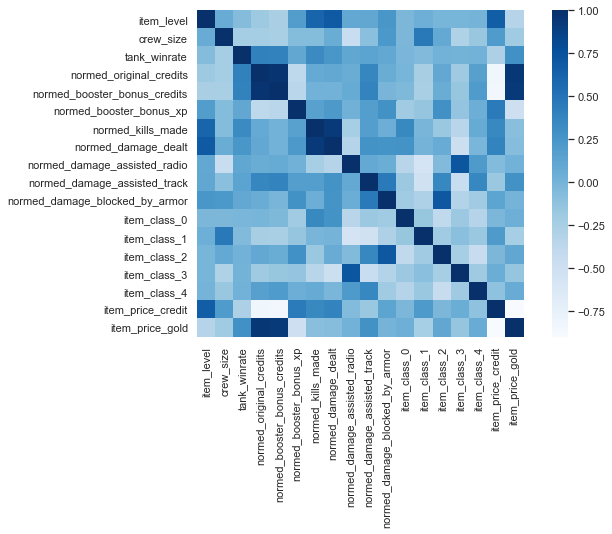

item_price_credit                -0.896133
normed_booster_bonus_xp          -0.484414
item_level                       -0.320670
item_class_1                     -0.231584
crew_size                        -0.199783
item_class_3                     -0.146911
normed_kills_made                -0.086818
normed_damage_dealt              -0.077885
normed_damage_blocked_by_armor    0.000725
normed_damage_assisted_radio      0.021985
item_class_0                      0.042988
item_class_4                      0.073605
item_class_2                      0.110902
normed_damage_assisted_track      0.288448
tank_winrate                      0.294401
normed_booster_bonus_credits      0.926790
normed_original_credits           0.947014
item_price_gold                   1.000000
Name: item_price_gold, dtype: float64

In [36]:
corr = dataset.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, square=True, cmap='Blues')

plt.show()

corr['item_price_gold'].sort_values()

# Regression model

In [36]:
res_data = dataset.groupby('vehicle_type_cd').mean().reset_index()
tank_params = res_data[res_data['vehicle_type_cd'] == 9217]
res_data = res_data[res_data['vehicle_type_cd'] != 9217]

res_data.drop(columns=['vehicle_type_cd'], inplace=True, axis=1)

features = list(res_data.columns)
features.remove('item_price_credit'); features.remove('item_price_gold')
target_credit = ['item_price_credit']
target_gold = ['item_price_gold']

credit_dataset = res_data[res_data['item_price_credit'] != 0][features + target_credit]
gold_dataset = res_data[res_data['item_price_gold'] != 0][features + target_gold]

credit_dataset.index = np.arange(len(credit_dataset))
gold_dataset.index = np.arange(len(gold_dataset))

gold_dataset

,item_level,crew_size,tank_winrate,normed_original_credits,normed_booster_bonus_credits,normed_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_class_0,item_class_1,item_class_2,item_class_3,item_class_4,item_price_gold
0,8,4,0.506267,25970.290945,2736.044268,51.707355,0.326406,515.536840,235.324641,44.554937,242.548380,0.0,0.0,0.0,0.0,1.0,7500
1,6,5,0.463636,12532.157227,342.959106,69.640636,0.252768,275.389984,136.036466,22.578394,89.792810,0.0,0.0,0.0,0.0,1.0,3650
2,7,4,0.519171,18779.430044,1395.029753,50.298401,0.282884,336.289615,362.973959,23.944889,13.624500,0.0,0.0,0.0,1.0,0.0,4800
3,8,4,0.507127,24328.035359,2362.927331,41.605868,0.303799,533.567798,201.514744,41.314804,437.099212,0.0,0.0,1.0,0.0,0.0,12250
4,8,4,0.520461,26945.715708,2520.330405,66.120577,0.377359,648.817659,172.475903,36.377361,421.463095,0.0,0.0,1.0,0.0,0.0,10700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,8,5,0.500746,22807.830939,2564.983993,42.688580,0.326916,514.854381,188.238064,41.088607,115.652264,0.0,0.0,1.0,0.0,0.0,11900
74,8,4,0.471309,21390.221520,1724.644677,41.206081,0.269599,433.937143,203.525358,34.025577,68.488919,0.0,0.0,0.0,0.0,1.0,8700
75,8,4,0.505991,24017.945040,2022.342377,46.662085,0.284710,505.588416,183.902337,36.705733,565.578612,0.0,0.0,1.0,0.0,0.0,10500
76,6,5,0.527875,14809.313171,677.386054,36.757955,0.293406,284.635468,258.165713,12.745797,0.658380,0.0,0.0,0.0,1.0,0.0,3500


In [37]:
credit_scaler = StandardScaler()
gold_scaler = StandardScaler()

normed_credit_dataset = pd.DataFrame(credit_scaler.fit_transform(credit_dataset), columns=[features + target_credit])
normed_gold_dataset = pd.DataFrame(gold_scaler.fit_transform(gold_dataset), columns=[features + target_gold])

normed_gold_dataset

,item_level,crew_size,tank_winrate,normed_original_credits,normed_booster_bonus_credits,normed_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_class_0,item_class_1,item_class_2,item_class_3,item_class_4,item_price_gold
0,0.563093,-0.505361,0.086615,0.821189,1.037037,0.670465,-0.061068,0.101825,0.620615,0.913036,0.116938,-0.48795,0.0,-0.748331,-0.338062,1.374369,-0.379081
1,-2.815463,0.853887,-1.999644,-2.223227,-2.088454,2.735450,-1.307909,-2.106503,-0.838739,-1.126412,-0.651864,-0.48795,0.0,-0.748331,-0.338062,1.374369,-1.857688
2,-1.126185,-0.505361,0.718087,-0.807905,-0.714396,0.508227,-0.797989,-1.546486,2.496827,-0.999600,-1.035212,-0.48795,0.0,-0.748331,2.958040,-0.727607,-1.416026
3,0.563093,-0.505361,0.128704,0.449135,0.549728,-0.492703,-0.443861,0.267633,0.123672,0.612348,1.096093,-0.48795,0.0,1.336306,-0.338062,-0.727607,1.445175
4,0.563093,-0.505361,0.781236,1.042172,0.755304,2.330121,0.801647,1.327441,-0.303146,0.154148,1.017398,-0.48795,0.0,1.336306,-0.338062,-0.727607,0.849891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.563093,0.853887,-0.183598,0.104732,0.813624,-0.368030,-0.052449,0.095549,-0.071471,0.591357,-0.521717,-0.48795,0.0,1.336306,-0.338062,-0.727607,1.310756
74,0.563093,-0.505361,-1.624141,-0.216428,-0.283902,-0.538737,-1.022924,-0.648544,0.153224,-0.064101,-0.759085,-0.48795,0.0,-0.748331,-0.338062,1.374369,0.081784
75,0.563093,-0.505361,0.073079,0.378884,0.104906,0.089511,-0.767070,0.010342,-0.135198,0.184621,1.742716,-0.48795,0.0,1.336306,-0.338062,-0.727607,0.773081
76,-2.815463,0.853887,1.144019,-1.707336,-1.651675,-1.050931,-0.619833,-2.021484,0.956338,-2.038889,-1.100469,-0.48795,0.0,-0.748331,2.958040,-0.727607,-1.915296


In [38]:
train_data = np.array(normed_gold_dataset.drop(columns=['item_price_gold']))
train_labels = np.array(normed_gold_dataset[['item_price_gold']])

In [39]:
pca = PCA(n_components=0.95)
train_data = pca.fit_transform(train_data)

pca.explained_variance_ratio_

array([0.31675382, 0.16910647, 0.14820407, 0.1194058 , 0.06892763,
       0.04935847, 0.03729098, 0.03103759, 0.01978964])

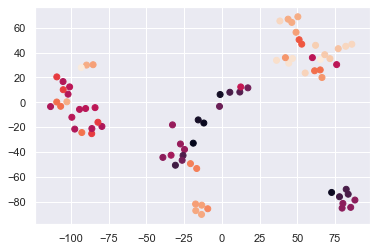

In [54]:
tsne = TSNE(n_components=2, perplexity=5)

x = tsne.fit_transform(train_data)
plt.scatter(x[:, 0], x[:, 1], c=train_labels)
plt.show()

In [ ]:
inds = np.where((x[:,0] < -1000) | (x[:,0] > 1000))

df = pd.DataFrame(gold_scaler.inverse_transform(normed_gold_dataset.iloc[inds[0]]))
df.columns = gold_dataset.columns
df

In [ ]:
dataset[(dataset['item_price_gold'] == 5750) & (abs(dataset['mean_original_credits'] - 37207) < 1)]

Train on 70 samples, validate on 8 samples
Epoch 1/120
70/70 [==============================] - 3s 39ms/sample - loss: 0.8650 - val_loss: 0.8886
Epoch 2/120
70/70 [==============================] - 0s 521us/sample - loss: 0.5868 - val_loss: 0.6279
Epoch 3/120
70/70 [==============================] - 0s 444us/sample - loss: 0.4461 - val_loss: 0.4855
Epoch 4/120
70/70 [==============================] - 0s 753us/sample - loss: 0.3376 - val_loss: 0.4466
Epoch 5/120
70/70 [==============================] - 0s 672us/sample - loss: 0.2909 - val_loss: 0.3899
Epoch 6/120
70/70 [==============================] - 0s 573us/sample - loss: 0.2658 - val_loss: 0.3647
Epoch 7/120
70/70 [==============================] - 0s 434us/sample - loss: 0.2262 - val_loss: 0.3649
Epoch 8/120
70/70 [==============================] - 0s 557us/sample - loss: 0.3087 - val_loss: 0.3159
Epoch 9/120
70/70 [==============================] - 0s 718us/sample - loss: 0.2327 - val_loss: 0.3629
Epoch 10/120
70/70 [===========

70/70 [==============================] - 0s 451us/sample - loss: 0.0497 - val_loss: 0.2047
Epoch 80/120
70/70 [==============================] - 0s 520us/sample - loss: 0.0614 - val_loss: 0.2037
Epoch 81/120
70/70 [==============================] - 0s 386us/sample - loss: 0.0399 - val_loss: 0.2274
Epoch 82/120
70/70 [==============================] - 0s 453us/sample - loss: 0.0375 - val_loss: 0.2138
Epoch 83/120
70/70 [==============================] - 0s 336us/sample - loss: 0.0415 - val_loss: 0.1963
Epoch 84/120
70/70 [==============================] - 0s 331us/sample - loss: 0.0423 - val_loss: 0.2337
Epoch 85/120
70/70 [==============================] - 0s 424us/sample - loss: 0.0547 - val_loss: 0.1970
Epoch 86/120
70/70 [==============================] - 0s 468us/sample - loss: 0.0444 - val_loss: 0.1981
Epoch 87/120
70/70 [==============================] - 0s 392us/sample - loss: 0.0521 - val_loss: 0.2312
Epoch 88/120
70/70 [==============================] - 0s 359us/sample - loss:

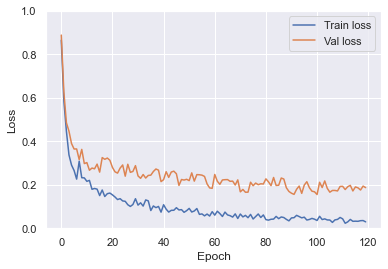

In [40]:
epochs = 120

model = build_network(train_data.shape[1])
history = model.fit(train_data, train_labels,
                    validation_split=0.1,
                    epochs=epochs, shuffle=True)

plot_network_history(history)

In [63]:
full_model = build_network(train_data.shape[1])
history = full_model.fit(train_data, train_labels,
                         epochs=epochs, shuffle=True)

Train on 78 samples
Epoch 1/120
78/78 [==============================] - 1s 9ms/sample - loss: 1.2460
Epoch 2/120
78/78 [==============================] - 0s 90us/sample - loss: 0.8138
Epoch 3/120
78/78 [==============================] - 0s 115us/sample - loss: 0.6067
Epoch 4/120
78/78 [==============================] - 0s 128us/sample - loss: 0.4976
Epoch 5/120
78/78 [==============================] - 0s 179us/sample - loss: 0.3877
Epoch 6/120
78/78 [==============================] - 0s 115us/sample - loss: 0.3789
Epoch 7/120
78/78 [==============================] - 0s 115us/sample - loss: 0.3106
Epoch 8/120
78/78 [==============================] - 0s 128us/sample - loss: 0.2545
Epoch 9/120
78/78 [==============================] - 0s 110us/sample - loss: 0.2599
Epoch 10/120
78/78 [==============================] - 0s 141us/sample - loss: 0.2224
Epoch 11/120
78/78 [==============================] - 0s 115us/sample - loss: 0.2243
Epoch 12/120
78/78 [==============================] - 0s 

In [88]:
tank_params.drop(columns=['vehicle_type_cd', 'item_price_credit', 'item_price_gold'], inplace=True, axis=1)
tank_params

,item_level,crew_size,tank_winrate,normed_original_credits,normed_booster_bonus_credits,normed_booster_bonus_xp,normed_kills_made,normed_damage_dealt,normed_damage_assisted_radio,normed_damage_assisted_track,normed_damage_blocked_by_armor,item_class_0,item_class_1,item_class_2,item_class_3,item_class_4
118,8,4,0.497093,22802.106274,1811.599614,41.860559,0.321928,525.343918,168.491483,42.112574,444.023326,0.0,0.0,1.0,0.0,0.0


In [67]:
def predict(tank_params):
    tank_params['item_price_gold'] = 0
    
    scaled = gold_scaler.transform(tank_params)[:,:len(tank_params.columns) - 1]
    pca_components = pca.transform(scaled)
    
    pred_full = full_model.predict(pca_components)
    pred = model.predict(pca_components)
    
    x_full = np.concatenate((scaled[0], pred_full[0]))
    x = np.concatenate((scaled[0], pred[0]))
    
    return gold_scaler.inverse_transform(x_full)[-1], gold_scaler.inverse_transform(x)[-1]

predict(tank_params)

(11860.027000267626, 12169.47730677915)

# Tests

In [ ]:
damage = arena_members[arena_members['vehicle_type_cd'] == 9217][['account_db_id', 'kills_made', 'kills_made_normed_by_lvl', 'player_winrate_ML']]
damage = damage[damage.groupby('account_db_id')['account_db_id'].transform('count') > 2]

pl = damage.groupby('account_db_id').agg({'kills_made' : lambda g: g.mean(),
                                          'kills_made_normed_by_lvl' : lambda g: g.mean(),
                                          'player_winrate_ML' : 'mean'})
pl['normed'] = (1 - pl['player_winrate_ML']) * pl['kills_made_normed_by_lvl']

plt.hist(pl['kills_made'], bins=50, alpha=0.7)
plt.hist(pl['normed'], bins=50, color='r', alpha=0.5)
plt.show()

In [86]:
gb = GradientBoostingRegressor(n_estimators=400, max_depth=6, min_samples_split=4)
rf = RandomForestRegressor(n_estimators=400, max_depth=10, min_samples_split=6)
svm = SVR(C=100, gamma=0.01, kernel='rbf')
ab = AdaBoostRegressor(learning_rate=0.1, loss='square', n_estimators=400)
nn = KerasRegressor(build_fn=build_network, inputs=train_data.shape[1], epochs=120, validation_split=0.1)
nn._estimator_type = 'regressor'

model = VotingRegressor([('gb', gb),
                         ('rf', rf),
                         ('svm', svm),
                         ('ab', ab),
                         ('nn', nn)], weights=[1, 1, 1, 1, 1])

res = model.fit(train_data, train_labels)

Train on 70 samples, validate on 8 samples
Epoch 1/120
70/70 [==============================] - 1s 13ms/sample - loss: 0.8756 - val_loss: 0.6192
Epoch 2/120
70/70 [==============================] - 0s 376us/sample - loss: 0.5359 - val_loss: 0.3717
Epoch 3/120
70/70 [==============================] - 0s 258us/sample - loss: 0.4629 - val_loss: 0.2823
Epoch 4/120
70/70 [==============================] - 0s 287us/sample - loss: 0.3424 - val_loss: 0.2590
Epoch 5/120
70/70 [==============================] - 0s 262us/sample - loss: 0.3075 - val_loss: 0.3039
Epoch 6/120
70/70 [==============================] - 0s 341us/sample - loss: 0.3174 - val_loss: 0.2417
Epoch 7/120
70/70 [==============================] - 0s 315us/sample - loss: 0.2185 - val_loss: 0.2136
Epoch 8/120
70/70 [==============================] - 0s 309us/sample - loss: 0.2671 - val_loss: 0.2180
Epoch 9/120
70/70 [==============================] - 0s 282us/sample - loss: 0.2097 - val_loss: 0.2077
Epoch 10/120
70/70 [===========

70/70 [==============================] - 0s 314us/sample - loss: 0.0505 - val_loss: 0.1969
Epoch 80/120
70/70 [==============================] - 0s 298us/sample - loss: 0.0623 - val_loss: 0.2117
Epoch 81/120
70/70 [==============================] - 0s 339us/sample - loss: 0.0583 - val_loss: 0.2325
Epoch 82/120
70/70 [==============================] - 0s 286us/sample - loss: 0.0610 - val_loss: 0.2370
Epoch 83/120
70/70 [==============================] - 0s 294us/sample - loss: 0.0374 - val_loss: 0.2140
Epoch 84/120
70/70 [==============================] - 0s 280us/sample - loss: 0.0494 - val_loss: 0.2451
Epoch 85/120
70/70 [==============================] - 0s 256us/sample - loss: 0.0399 - val_loss: 0.2240
Epoch 86/120
70/70 [==============================] - 0s 284us/sample - loss: 0.0451 - val_loss: 0.2058
Epoch 87/120
70/70 [==============================] - 0s 343us/sample - loss: 0.0382 - val_loss: 0.2115
Epoch 88/120
70/70 [==============================] - 0s 322us/sample - loss:

In [89]:
tank_params['item_price_gold'] = 0

scaled = gold_scaler.transform(tank_params)[:,:len(tank_params.columns) - 1]
pca_components = pca.transform(scaled)
    
pred = model.predict(pca_components)
x = np.concatenate((scaled[0], pred))

gold_scaler.inverse_transform(x)[-1]

11623.963304051022

In [41]:
train_x, train_y = train_data[:70], train_labels[:70]
test_x, test_y = train_data[70:], train_labels[70:]

Train on 70 samples, validate on 8 samples
Epoch 1/120
70/70 [==============================] - 1s 11ms/sample - loss: 1.6699 - val_loss: 1.8358
Epoch 2/120
70/70 [==============================] - 0s 255us/sample - loss: 1.1109 - val_loss: 1.4739
Epoch 3/120
70/70 [==============================] - 0s 331us/sample - loss: 0.8998 - val_loss: 1.2178
Epoch 4/120
70/70 [==============================] - 0s 331us/sample - loss: 0.7737 - val_loss: 1.0180
Epoch 5/120
70/70 [==============================] - 0s 369us/sample - loss: 0.6329 - val_loss: 0.8493
Epoch 6/120
70/70 [==============================] - 0s 303us/sample - loss: 0.5532 - val_loss: 0.6881
Epoch 7/120
70/70 [==============================] - 0s 329us/sample - loss: 0.4801 - val_loss: 0.6255
Epoch 8/120
70/70 [==============================] - 0s 359us/sample - loss: 0.4292 - val_loss: 0.5307
Epoch 9/120
70/70 [==============================] - 0s 343us/sample - loss: 0.4238 - val_loss: 0.4696
Epoch 10/120
70/70 [===========

70/70 [==============================] - 0s 330us/sample - loss: 0.0547 - val_loss: 0.1712
Epoch 80/120
70/70 [==============================] - 0s 273us/sample - loss: 0.0674 - val_loss: 0.1719
Epoch 81/120
70/70 [==============================] - 0s 289us/sample - loss: 0.0581 - val_loss: 0.1583
Epoch 82/120
70/70 [==============================] - 0s 304us/sample - loss: 0.0443 - val_loss: 0.1788
Epoch 83/120
70/70 [==============================] - 0s 286us/sample - loss: 0.0474 - val_loss: 0.1612
Epoch 84/120
70/70 [==============================] - 0s 271us/sample - loss: 0.0519 - val_loss: 0.1714
Epoch 85/120
70/70 [==============================] - 0s 370us/sample - loss: 0.0444 - val_loss: 0.1898
Epoch 86/120
70/70 [==============================] - 0s 311us/sample - loss: 0.0603 - val_loss: 0.1992
Epoch 87/120
70/70 [==============================] - 0s 302us/sample - loss: 0.0630 - val_loss: 0.1940
Epoch 88/120
70/70 [==============================] - 0s 272us/sample - loss:

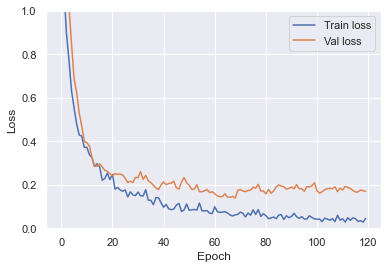

In [52]:
epochs = 120

model = build_network(train_data.shape[1])
history = model.fit(x=train_x, y=train_y,
                    validation_data=(test_x, test_y),
                    epochs=epochs, shuffle=True)

plot_network_history(history)

In [147]:
gb = GradientBoostingRegressor(n_estimators=200, max_depth=4)
gb.fit(train_x, train_y)

mean_squared_error(gb.predict(test_x), test_y)

0.209077044630903

In [93]:
rf = RandomForestRegressor(n_estimators=600, max_depth=10, min_samples_split=6)

rf.fit(train_x, train_y)

mean_squared_error(rf.predict(test_x), test_y)

0.17002055984162856

In [102]:
svm1 = SVR(C=10, gamma=0.01, kernel='rbf')

svm1.fit(train_x, train_y)

mean_squared_error(svm1.predict(test_x), test_y)

0.21645343020800195

In [122]:
svm2 = SVR(C=10, gamma=0.01, coef0=100, degree=2, kernel='poly')

svm2.fit(train_x, train_y)

mean_squared_error(svm2.predict(test_x), test_y)

0.2581288352314947

In [134]:
ab = AdaBoostRegressor(learning_rate=0.1, loss='square', n_estimators=600)

ab.fit(train_x, train_y)

mean_squared_error(ab.predict(test_x), test_y)

0.14019298826040233

In [148]:
gb = GradientBoostingRegressor(n_estimators=200, max_depth=4)
rf = RandomForestRegressor(n_estimators=600, max_depth=10, min_samples_split=6)
svm1 = SVR(C=10, gamma=0.01, kernel='rbf')
svm2 = SVR(C=10, gamma=0.01, coef0=100, degree=2, kernel='poly')
ab = AdaBoostRegressor(learning_rate=0.1, loss='square', n_estimators=600)
nn = KerasRegressor(build_fn=build_network, inputs=train_data.shape[1], epochs=120)
nn._estimator_type = 'regressor'

model = VotingRegressor([('gb', gb),
                         ('rf', rf),
                         ('svm1', svm1),
                         ('svm2', svm2),
                         ('ab', ab),
                         ('nn', nn)], weights=[1, 1, 1, 1, 1, 1])

res = model.fit(train_x, train_y)

mse = 0
for i, x in enumerate(test_x):
    pr = model.predict(x.reshape(1, -1))
    mse += (pr - test_y[i]) ** 2

mse / len(test_x)

Train on 70 samples
Epoch 1/120
70/70 [==============================] - 1s 14ms/sample - loss: 1.2958
Epoch 2/120
70/70 [==============================] - 0s 272us/sample - loss: 0.8259
Epoch 3/120
70/70 [==============================] - 0s 229us/sample - loss: 0.6264
Epoch 4/120
70/70 [==============================] - 0s 398us/sample - loss: 0.4936
Epoch 5/120
70/70 [==============================] - 0s 347us/sample - loss: 0.4602
Epoch 6/120
70/70 [==============================] - 0s 283us/sample - loss: 0.4229
Epoch 7/120
70/70 [==============================] - 0s 256us/sample - loss: 0.3793
Epoch 8/120
70/70 [==============================] - 0s 150us/sample - loss: 0.3049
Epoch 9/120
70/70 [==============================] - 0s 260us/sample - loss: 0.2937
Epoch 10/120
70/70 [==============================] - 0s 299us/sample - loss: 0.2780
Epoch 11/120
70/70 [==============================] - 0s 303us/sample - loss: 0.3018
Epoch 12/120
70/70 [==============================] - 0

Epoch 97/120
70/70 [==============================] - 0s 200us/sample - loss: 0.0481
Epoch 98/120
70/70 [==============================] - 0s 223us/sample - loss: 0.0487
Epoch 99/120
70/70 [==============================] - 0s 159us/sample - loss: 0.0428
Epoch 100/120
70/70 [==============================] - 0s 200us/sample - loss: 0.0339
Epoch 101/120
70/70 [==============================] - 0s 216us/sample - loss: 0.0449
Epoch 102/120
70/70 [==============================] - 0s 157us/sample - loss: 0.0491
Epoch 103/120
70/70 [==============================] - 0s 213us/sample - loss: 0.0394
Epoch 104/120
70/70 [==============================] - 0s 200us/sample - loss: 0.0521
Epoch 105/120
70/70 [==============================] - 0s 209us/sample - loss: 0.0481
Epoch 106/120
70/70 [==============================] - 0s 237us/sample - loss: 0.0464
Epoch 107/120
70/70 [==============================] - 0s 230us/sample - loss: 0.0340
Epoch 108/120
70/70 [==============================] - 0s

array([0.17399409])